In [ ]:
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils import normalize, rgb2gray, compute_entropy, compute_gradients
from denoiser import tv_norm, DATA_PATH
from regularizer import laplacian3

from scipy.ndimage import gaussian_filter, binary_erosion, binary_dilation, generate_binary_structure, label, sobel, uniform_filter
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import torch
import torch.nn.functional as F

In [254]:
image_id = 0
original = np.array(Image.open(f"{DATA_PATH}/original/{image_id:03d}.png"))[:, :, :3]
noised = np.array(Image.open(f"{DATA_PATH}/noised/{image_id:03d}.jpg"))

original = normalize(original)
noised = normalize(noised)
print(original.shape, noised.shape)

(600, 600, 3) (600, 600, 3)


In [162]:
def laplacian_and_show(x, c1=2, c2=5, plot=True):
    
    # x = gaussian_filter(x, 1)
    kernel = laplacian_kernel
    padding = (kernel.shape[2] - 1)//2
    r = (
        F.conv2d(torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0), kernel, padding=padding)
        .squeeze()
        # .squeeze().detach().numpy()
    )

    r1 = F.sigmoid(r*c1)
    r2 = F.sigmoid(r*c2)

    kernel = horizontal_kernel
    padding = (kernel.shape[2] - 1)//2
    r3 = F.conv2d(r2.unsqueeze(0).unsqueeze(0),
                  kernel,
                  padding=padding).squeeze()
    kernel = vertical_kernel
    r4 = F.conv2d(r2.unsqueeze(0).unsqueeze(0),
                  kernel,
                  padding=padding).squeeze()
    r5 = torch.cat([r3.unsqueeze(0), r4.unsqueeze(0)], dim=0).max(dim=0)[0]

    if plot:
        print(f"tv norm of laplacian response:\t{tv_norm(r.unsqueeze(0).unsqueeze(0)).item():.06f}")
        print(f"tv norm of r2(c2={c2}):\t{tv_norm(r2.unsqueeze(0).unsqueeze(0)).item():.06f}")
        print(f"l1 distance between r1 and r2:\t{(r1-r2).abs().mean().item():.06f}")

        show_index = slice(400, 450), slice(400, 450)
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(normalize(x)[show_index], cmap='gray')
        plt.title("input")
        plt.grid()

        plt.grid()
        plt.subplot(1, 4, 2)
        plt.imshow(r[show_index], cmap='gray')
        plt.title("laplacian response")
        plt.grid()
        
        plt.subplot(1, 4, 3)
        plt.imshow((r1)[show_index], cmap='gray', vmin=0, vmax=1)
        plt.title(f"r1")
        plt.grid()

        plt.subplot(1,4,4)
        plt.imshow((r2)[show_index], cmap='gray', vmin=0, vmax=1)
        # plt.imshow((r2-r1).abs()[show_index], cmap='gray')
        # plt.title(f"l1 distance between r1 and r2")
        # plt.imshow((normalize(r5[show_index])>0.5), cmap='gray', vmin=0, vmax=1)
        # plt.imshow((r5[show_index]), cmap='gray')
        plt.title(f"r2")
        plt.grid()

        plt.show()  
    return r, r1, r2, r5

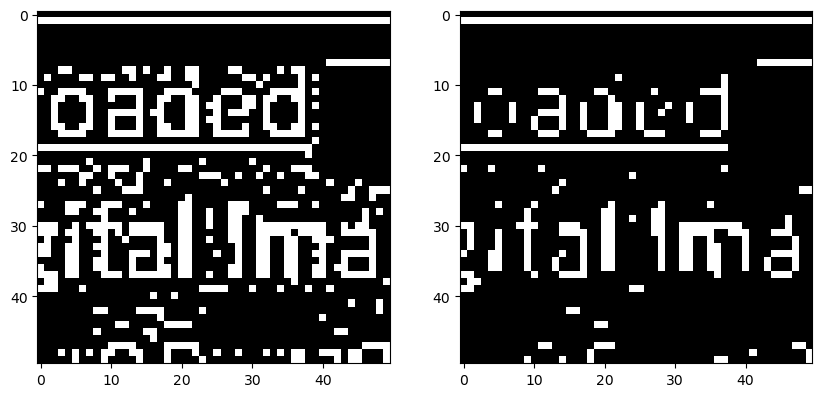

In [160]:
r, r1, r2, r5 = laplacian_and_show(noised, c1=2, c2=5, plot=False)
show_index = slice(400, 450), slice(400, 450)

vertical_line_structure = np.array([[0, 1, 0],
                                    [0, 1, 0],
                                    [0, 1, 0]])
horizontal_line_structure = np.array([[0, 0, 0],
                                      [1, 1, 1],
                                      [0, 0, 0]])

r2_binary = (r2>0.6).detach().numpy()
r2_binary_vertical_eroded = binary_erosion(r2_binary, structure=vertical_line_structure)
r2_binary_horizontal_eroded = binary_erosion(r2_binary, structure=horizontal_line_structure)
r2_binary_eroded = r2_binary_vertical_eroded | r2_binary_horizontal_eroded

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(r2_binary[show_index], cmap='gray')
axes[1].imshow(r2_binary_eroded[show_index], cmap='gray')

tv norm of laplacian response:	0.084588
tv norm of r2(c2=10):	0.064453
l1 distance between r1 and r2:	0.039529


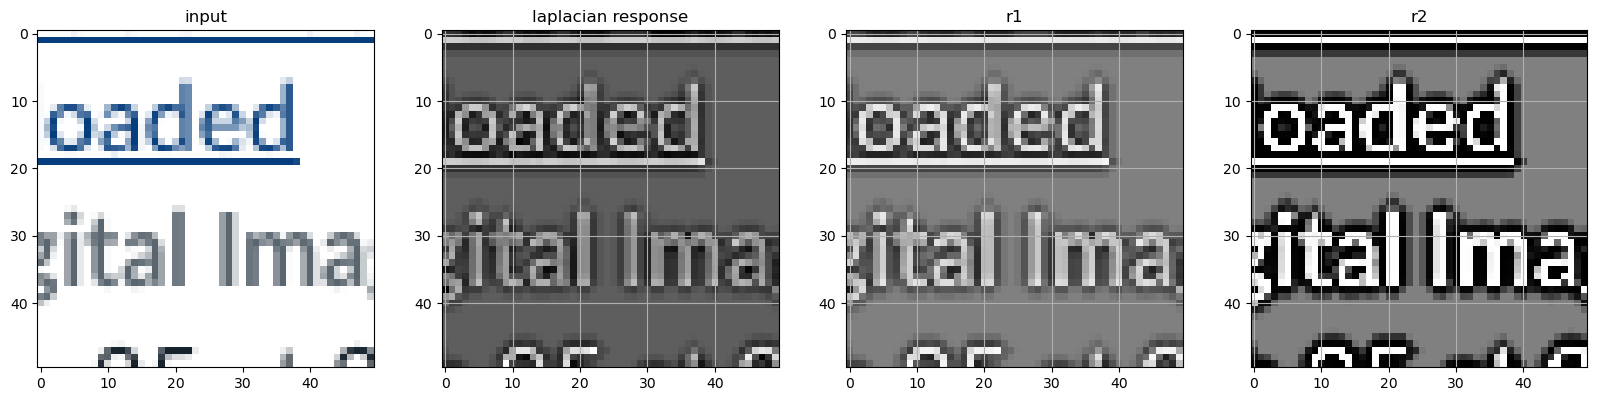

tv norm of laplacian response:	0.099995
tv norm of r2(c2=10):	0.095557
l1 distance between r1 and r2:	0.055920


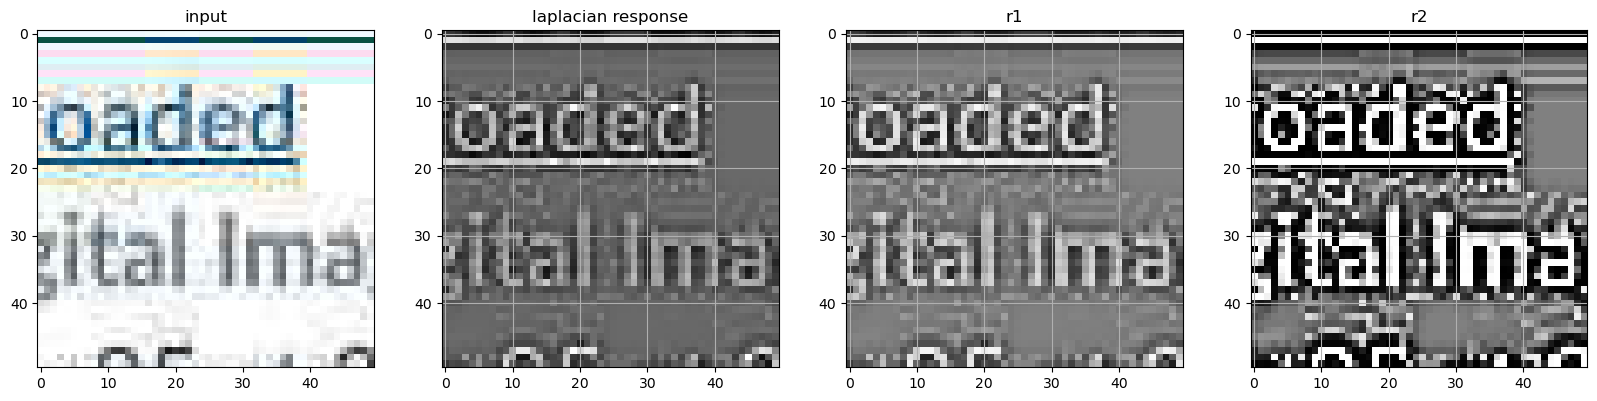

In [163]:
c1, c2 = 2, 10

laplacian_and_show(original, c1, c2)
laplacian_and_show(noised, c1, c2)
print()

In [ ]:
original_gray = rgb2gray(original)
noised_gray = rgb2gray(noised)

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(noised_gray[show_index], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(noised_no_block_artifact[show_index], cmap='gray')
plt.show()

(600, 600, 3) (600, 600, 3)


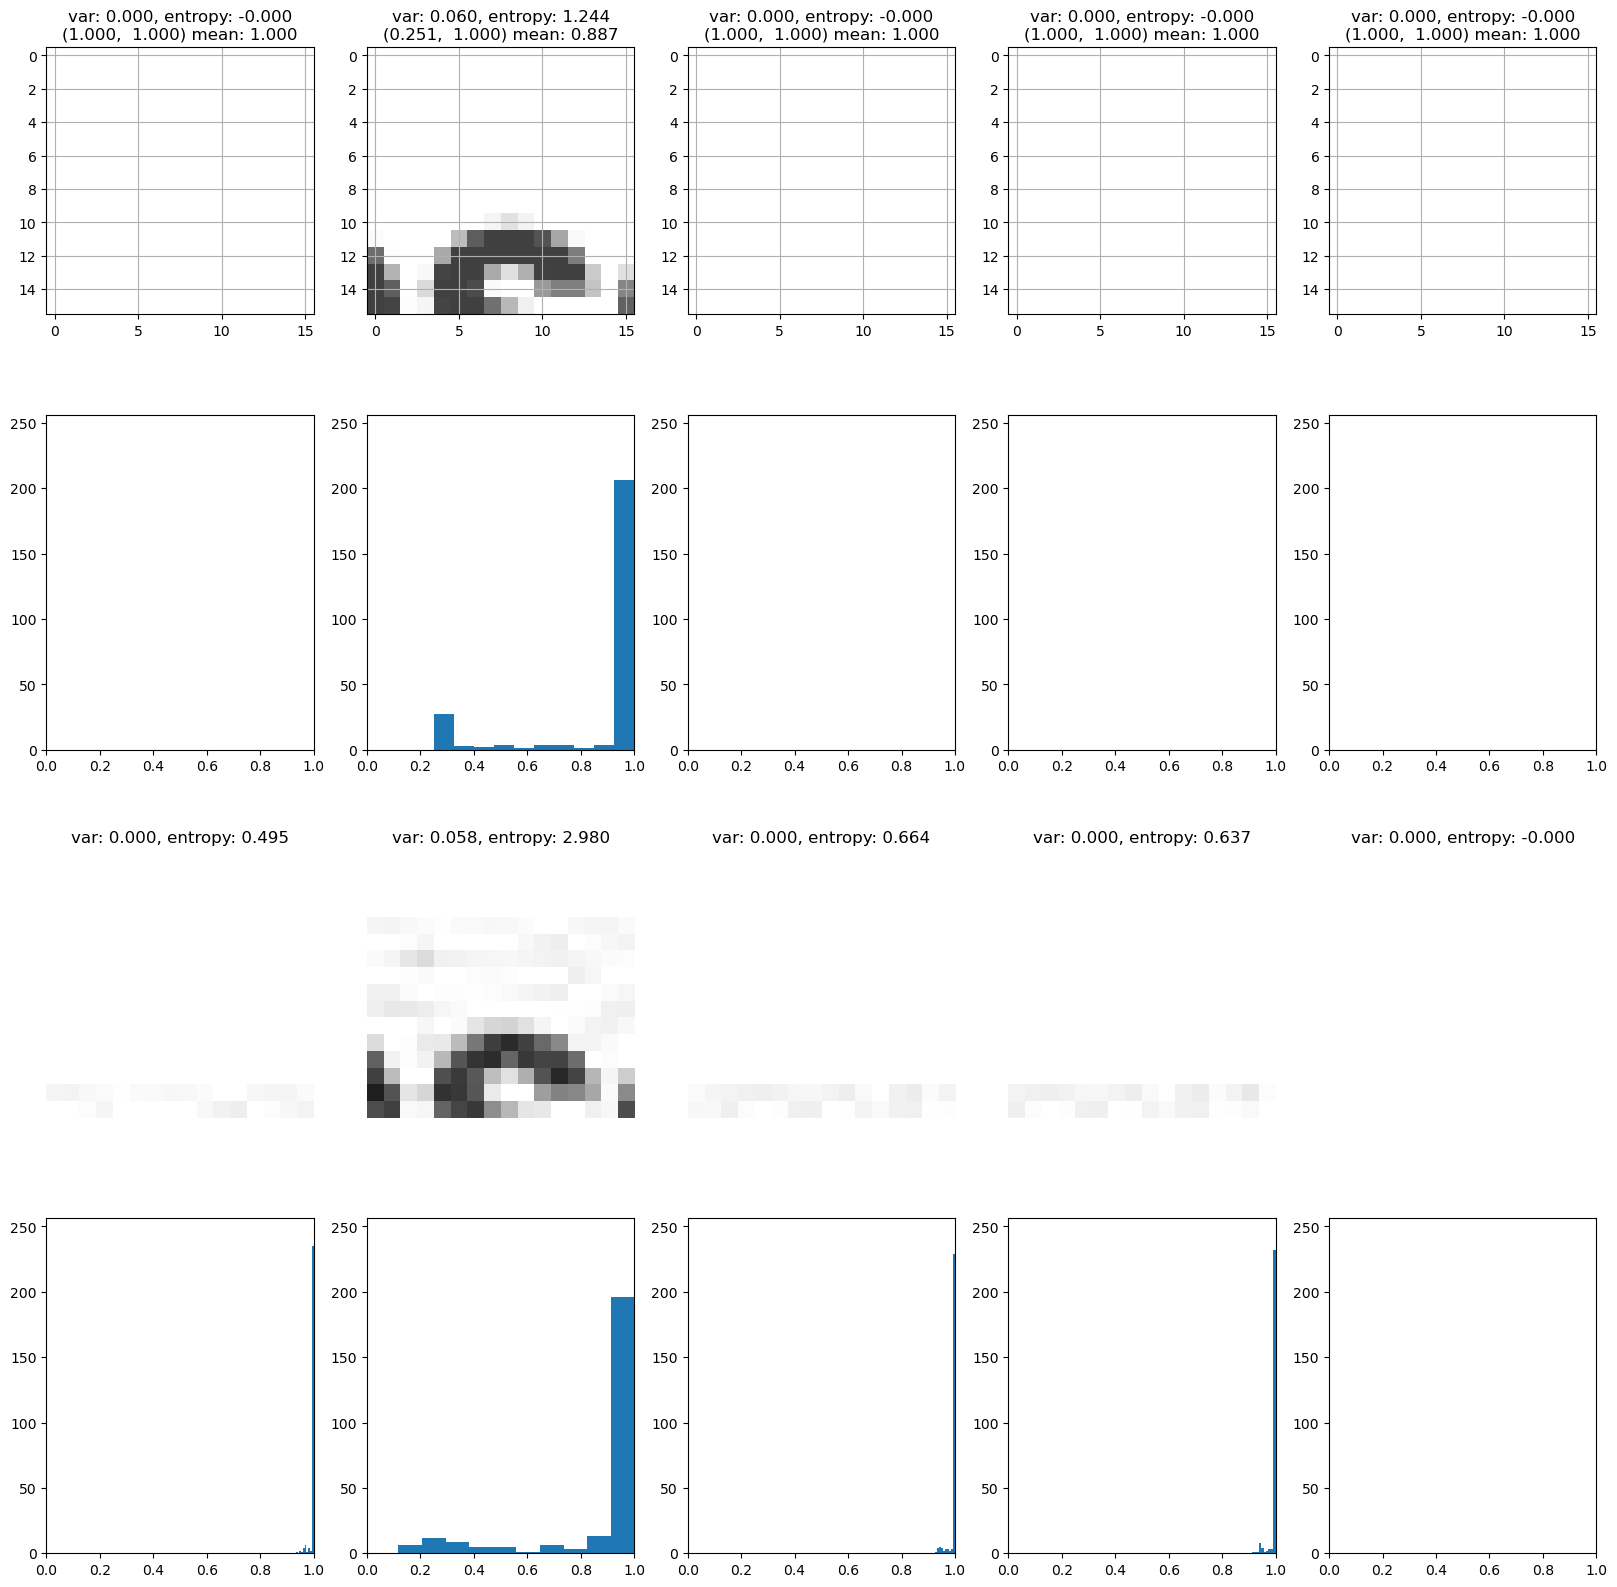

In [256]:
print(original.shape, noised.shape)

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
patch_size = 16
toplefts = [
    (410, 420),  (420, 420), (410, 438), (410, 440), (400, 430),
]

original_edges = laplacian3(original)
noised_edges = laplacian3(noised)

original_gray = rgb2gray(original)
noised_gray = rgb2gray(noised)

for i, (x,y) in enumerate(toplefts):
    patch_slice = slice(x, x+patch_size), slice(y, y+patch_size)
    clean_patch = (original_gray[patch_slice])
    noisy_patch = (noised_gray[patch_slice])
    # clean_patch = F.sigmoid(original_edges[x:x+patch_size, y:y+patch_size])
    # noisy_patch = F.sigmoid(noised_edges[x:x+patch_size, y:y+patch_size])


    clean_var = clean_patch.var().item()
    noisy_var = noisy_patch.var().item()

    clean_entropy = compute_entropy(clean_patch.flatten())
    noisy_entropy = compute_entropy(noisy_patch.flatten())

    axes[0, i].imshow(clean_patch, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f"var: {clean_var:.03f}, entropy: {clean_entropy:.03f}\n({clean_patch.min().item():.03f},  {clean_patch.max().item():.03f}) mean: {clean_patch.mean().item():.03f}")
    axes[0, i].grid()
    axes[1, i].hist(clean_patch.flatten(), bins=10)
    axes[1, i].set_ylim(0, len(clean_patch.flatten()))
    axes[1, i].set_xlim(0, 1)


    axes[2, i].imshow(noisy_patch, cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title(f"var: {noisy_var:.03f}, entropy: {noisy_entropy:.03f}")
    # axes[2, i].set_title(f"var: {noisy_var:.03f}, entropy: {noisy_entropy:.03f}\n({noisy_patch.min().item():.03f}, {noisy_patch.max().item():.03f}) mean: {noisy_patch.mean().item():.03f}")
    # axes[2, i].grid()
    axes[2, i].axis('off')
    axes[3, i].hist(noisy_patch.flatten(), bins=10)
    axes[3, i].set_ylim(0, len(noisy_patch.flatten()))
    axes[3, i].set_xlim(0, 1)

tv norm of lapaclian response: 0.100447 vs 0.119859


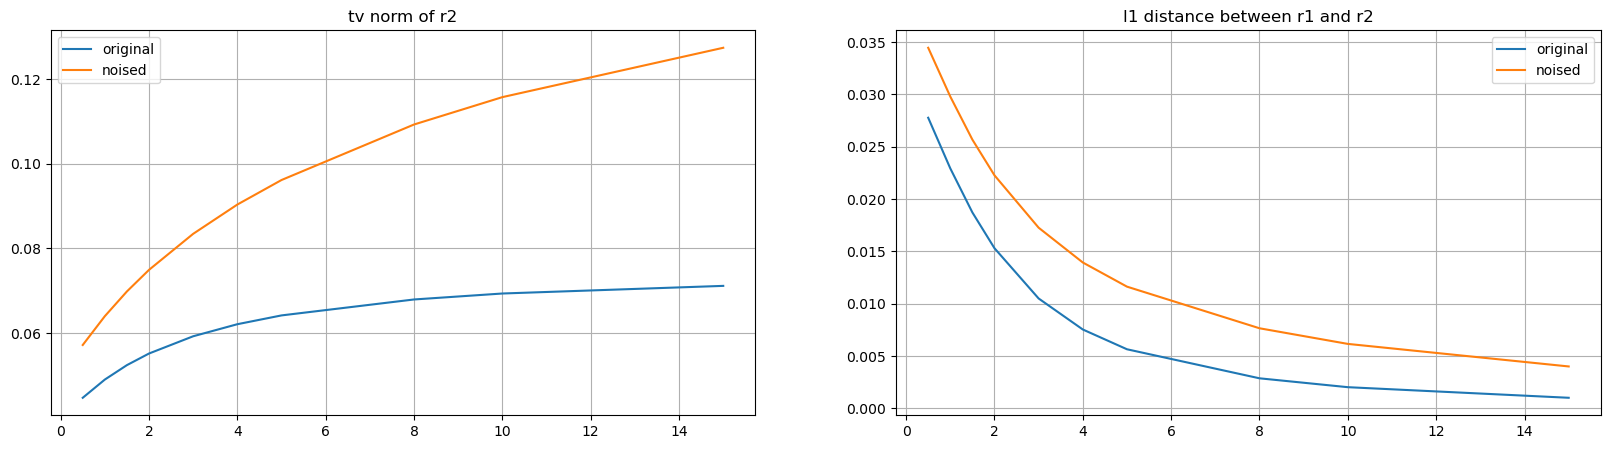

In [32]:
metrics_original = {
    "tv_norm_r2": [],
    "l1_distance_r1_r2": []
}
metrics_noised = {
    "tv_norm_r2": [],
    "l1_distance_r1_r2": []
}
cs = [0.5, 1, 1.5, 2, 3, 4, 5, 8, 10, 15]
for c in cs:
    original_responses = laplacian_and_show(original, c1=c, c2=c+2, plot=False)
    noised_responses = laplacian_and_show(noised, c1=c, c2=c+2, plot=False)
    
    metrics_original["tv_norm_r2"].append(tv_norm(original_responses[2].unsqueeze(0).unsqueeze(0)).item())
    metrics_original["l1_distance_r1_r2"].append((original_responses[1]-original_responses[2]).abs().mean().item())

    metrics_noised["tv_norm_r2"].append(tv_norm(noised_responses[2].unsqueeze(0).unsqueeze(0)).item())
    metrics_noised["l1_distance_r1_r2"].append((noised_responses[1]-noised_responses[2]).abs().mean().item())

print(f'tv norm of lapaclian response: {tv_norm(original_responses[0].unsqueeze(0).unsqueeze(0)).item():.6f} vs {tv_norm(noised_responses[0].unsqueeze(0).unsqueeze(0)).item():.6f}')

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(cs, metrics_original["tv_norm_r2"], label="original")
plt.plot(cs, metrics_noised["tv_norm_r2"], label="noised")
plt.title("tv norm of r2")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(cs, metrics_original["l1_distance_r1_r2"], label="original")
plt.plot(cs, metrics_noised["l1_distance_r1_r2"], label="noised")
plt.title("l1 distance between r1 and r2")
plt.legend()
plt.grid()

plt.show()


In [109]:
r, r1, r2, r5 = laplacian_and_show(noised, c1=2, c2=5, plot=False)

In [ ]:
magnitudes = compute_gradients(noised_gray, num_directions=4)

print(magnitudes.shape)

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(noised_gray[show_index], cmap='gray')
# axes[1].imshow(magnitudes[:,:,0][show_index], cmap='gray')
# axes[2].imshow(magnitudes[:,:,1][show_index], cmap='gray')

(600, 600, 4)


In [258]:
p = noised_gray
H, W = p.shape
magnitudes = compute_gradients(noised_gray, num_directions=2)

def bilateral_get_weight(i_range, j_range, i, j, p, gradient_magnitudes, sigma_s, sigma_r, sigma_o):
    patch = p[np.ix_(i_range, j_range)]
    center_gradient = gradient_magnitudes[i, j]
    neighbor_gradient = gradient_magnitudes[np.ix_(i_range, j_range)]
    w = np.exp(
        - ((patch - p[i, j])**2 / sigma_r**2)
        - ((i_range[:, None] - i)**2 / sigma_s**2)
        - ((j_range[None, :] - j)**2 / sigma_s**2)
    )

    # w_orientation = np.exp(
    #     - ((neighbor_gradient[:,:,0] - center_gradient[0])**2 / sigma_o**2)
    #     - ((neighbor_gradient[:,:,1] - center_gradient[1])**2 / sigma_o**2)
    # )

    orientation_distance = (np.linalg.norm(neighbor_gradient - center_gradient, axis=-1)**2)*np.linalg.norm(center_gradient)
    w_orientation = np.exp(-orientation_distance/sigma_o**2)

    # def softmax(x):
    #     exp_x = np.exp(x - np.max(x))
    #     return exp_x / exp_x.sum()
    # neighbor_gradient /= (np.linalg.norm(neighbor_gradient, axis=-1, keepdims=True)+1e-6)
    # w_orientation = neighbor_gradient.dot(center_gradient.reshape(-1, 1)).squeeze()
    # w_orientation = softmax(w_orientation)

    # dot_product = np.sum(neighbor_gradient * center_gradient, axis=-1)
    # norms = np.linalg.norm(neighbor_gradient, axis=-1) * np.linalg.norm(center_gradient)
    # orientation_similarity /= norms

    return w, w_orientation, w*w_orientation

In [259]:
def plot_weights(i, j):
    r = 6
    i_range = np.arange(max(i - r, 0), min(i + r + 1, H))
    j_range = np.arange(max(j - r, 0), min(j + r + 1, W))

    sigma_r = 0.3
    sigma_s = 5
    sigma_o = 0.5
    w_basic, w_orientation, w = bilateral_get_weight(i_range, j_range, i, j, p, magnitudes, sigma_s=sigma_s, sigma_r=sigma_r, sigma_o=sigma_o)

    plt.figure(figsize=(20, 5))
    titles = ['Patch', 'W', 'W_s*W_r', 'W_o']
    images = [p[np.ix_(i_range, j_range)], w, w_basic, w_orientation, p[np.ix_(i_range, j_range)]]
    for idx, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.scatter(r, r, c='r')
        plt.title(f"{title}({img.min():.5f}, {img.max():.5f})")
        plt.axis('off')
    plt.suptitle(f"sigma_r={sigma_r}, sigma_s={sigma_s}, sigma_o={sigma_o}")
    plt.show()

interact(plot_weights, 
         i=widgets.BoundedIntText(min=0, max=H-1, step=1, value=410, description='i:', style={'description_width': 'initial'}), 
         j=widgets.BoundedIntText(min=0, max=W-1, step=1, value=439, description='j:', style={'description_width': 'initial'}))

interactive(children=(BoundedIntText(value=410, description='i:', max=599, style=DescriptionStyle(description_…

<function __main__.plot_weights(i, j)>

In [ ]:



magnitudes = compute_gradients(noised_gray)

show_index = slice(400, 450), slice(400, 450)

sigma_r = 0.3
sigma_s = 5
sigma_o = 0.5

# guided_image = gaussian_filter(noised_gray, 0.7)
# guided_image = bilateral_filter(I=noised_gray, r=4, sigma_s=0.3, sigma_r=0.1)
print(f'sigma_r={sigma_r}, sigma_s={sigma_s}, sigma_o={sigma_o}')
guided_image = bilateral_filter(noised_gray,
                                gradient_magnitudes=magnitudes,
                                r=4,
                                sigma_s=sigma_s, sigma_r=sigma_r, sigma_o=sigma_o)

sigma_r=0.3, sigma_s=5, sigma_o=0.5


100%|██████████| 600/600 [00:14<00:00, 40.37it/s]


In [ ]:


def update_denoised(r, eps):
    denoised = guided_filter(I=guided_image, p=noised_gray, r=r, eps=eps)
    denoised = np.clip(denoised, 0, 1)

    titles = [
        'Clean Image',
        'Noisy Image',
        'After bilateral',
        'Final denoised Image'
    ]
    images = [original_gray, noised_gray, guided_image, denoised]
    fig, axes = plt.subplots(1, len(titles), figsize=(20, 5))

    # show_index = slice(150, 400), slice(200, 450)
    show_index = slice(100, 300), slice(0, 200)
    # show_index = slice(350, 450), slice(350, 450)
    # show_index = slice(400, 450), slice(400, 450)
    for i in range(4):
        min_val, max_val = images[i].min(), images[i].max()
        axes[i].imshow(images[i][show_index], cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'{titles[i]}')
        # axes[i].set_title(f'{titles[i]}({min_val:.03f}, {max_val:.03f})')
        # axes[i].grid()
        axes[i].axis('off')

    nosiy_mse = np.power(original_gray - noised_gray, 2).mean()
    mse = np.power(original_gray - denoised, 2).mean()
    mse_patch = np.power(original_gray[show_index] - denoised[show_index], 2).mean()
    psnr = 10 * np.log10(1 / mse)
    print(f"r={r} eps={eps:.7f}, PSNR: {psnr:.03f}, MSE: {mse:.06f}, MSE patch: {mse_patch:.06f}")
    plt.show()


interact(update_denoised, r=widgets.IntSlider(min=1, max=8, step=1, value=3), eps=widgets.FloatLogSlider(min=-6, max=0, step=0.1, value=0.00015, base=10))

sigmoid((variance-0.010)/0.1)


interactive(children=(IntSlider(value=3, description='r', max=8, min=1), FloatLogSlider(value=0.00015, descrip…

<function __main__.update_denoised(r, eps)>

r=3 eps=0.0000200, PSNR: 31.208, MSE: 0.000757, MSE patch: 0.000498


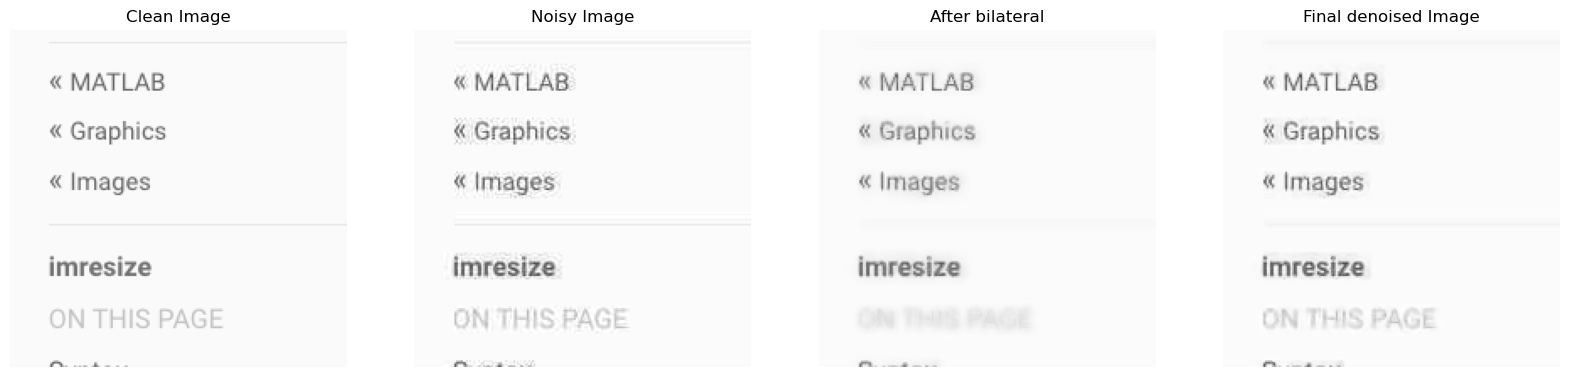

(600, 600)
(600, 600)
(600, 600)
(600, 600)


In [ ]:
titles = [
        'Clean Image',
        'Noisy Image',
        'After bilateral',
        'Final denoised Image'
    ]
images = update_denoised(3, 0.00002)
show_index =  slice(100, 300), slice(0, 200)
for image, title in zip(images, titles):
    print(image.shape)
    # save the image
    Image.fromarray((image[show_index]*255).astype(np.uint8)).save(f"../figures/{image_id:03d}_{title}-patch.png")
    # Image.fromarray((image*255).astype(np.uint8)).save(f"../figures/{image_id:03d}_{title}.png")

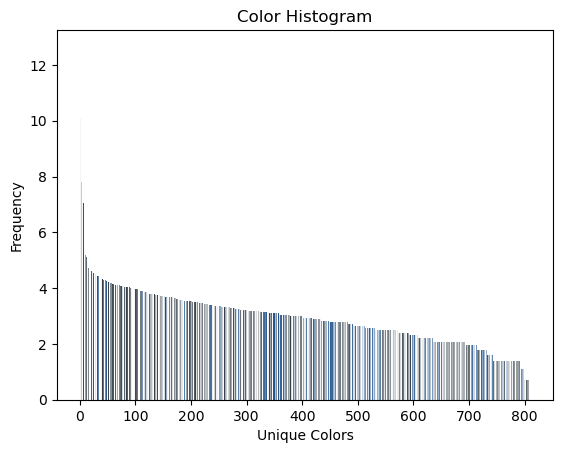

In [127]:
from collections import Counter
color_tuples = [tuple(rgb) for rgb in original.reshape(-1, 3)]
color_counts = Counter(color_tuples)
color_counts = dict(sorted(color_counts.items(), key=lambda x: x[1], reverse=True))

# Convert the histogram (Counter) to a list of unique colors and their counts
unique_colors, counts = zip(*color_counts.items())

# Converting to NumPy arrays for easier plotting
unique_colors = np.array(unique_colors)
counts = np.log(np.array(counts))

# Visualize the histogram of colors
plt.bar(range(len(counts)), counts, color=unique_colors / 255.0, edgecolor='none')
plt.xlabel("Unique Colors")
plt.ylabel("Frequency")
plt.title("Color Histogram")
plt.show()

-0.32980000000000587


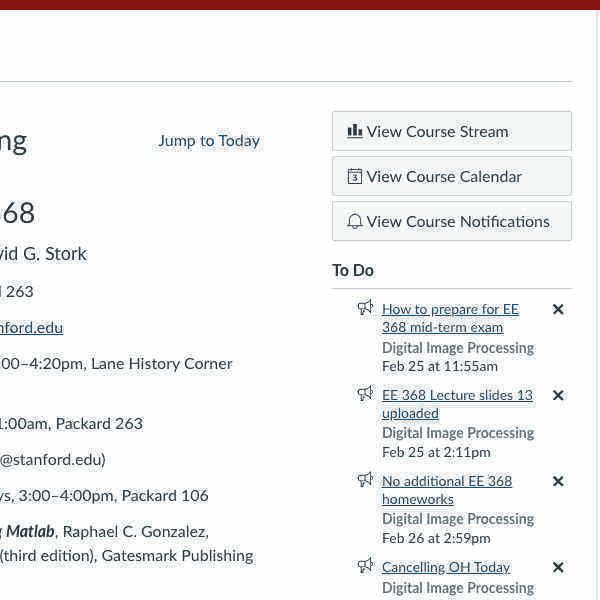

In [129]:
original_clustered, centers = cluster_colors(original, num_clusters=500)
print(np.mean(original_clustered)-np.mean(original))
Image.fromarray(denoised.astype(np.uint8))

[[254 254 254]
 [ 74  83  91]
 [177 181 185]
 [128  33  28]
 [127 135 142]
 [244 245 245]
 [206 209 211]
 [ 39  87 142]
 [ 48  59  68]
 [109 119 126]
 [151 156 161]
 [228 230 231]
 [ 96 131 171]
 [ 92 101 108]
 [148 172 199]
 [ 64 107 155]
 [180 184 188]
 [200 204 208]
 [178 195 215]
 [127 155 188]
 [ 55  66  75]
 [195 199 201]
 [214 217 219]
 [164 170 174]
 [137 144 149]
 [248 249 250]
 [ 81  90  98]
 [107 140 177]
 [ 63  73  81]
 [163 184 207]
 [ 72 112 158]
 [202 214 227]
 [239 240 240]
 [121 129 135]
 [158 164 168]
 [218 220 222]
 [ 34  83 139]
 [ 51  96 148]
 [ 85 123 166]
 [102 110 117]
 [187 191 194]
 [222 224 225]
 [130 138 144]
 [233 234 235]
 [218 226 235]
 [192 206 222]
 [135 162 192]
 [141 147 153]
 [118 126 132]
 [226 232 239]
 [ 85  94 101]
 [ 45  91 144]
 [169 174 178]
 [ 59  69  78]
 [212 221 232]
 [114 145 180]
 [ 67  77  85]
 [231 232 232]
 [144 151 156]
 [203 206 208]
 [232 237 243]
 [ 99 107 114]
 [ 78 117 162]
 [171 189 211]
 [155 177 202]
 [236 237 237]
 [252 252 

({0: 301362,
  1: 264,
  2: 270,
  3: 6000,
  4: 255,
  5: 24269,
  6: 323,
  7: 199,
  8: 1735,
  9: 1004,
  10: 379,
  11: 277,
  12: 142,
  13: 259,
  14: 127,
  15: 138,
  16: 198,
  17: 2449,
  18: 149,
  19: 124,
  20: 220,
  21: 214,
  22: 267,
  23: 253,
  24: 251,
  25: 208,
  26: 232,
  27: 99,
  28: 205,
  29: 142,
  30: 166,
  31: 89,
  32: 314,
  33: 208,
  34: 152,
  35: 302,
  36: 1239,
  37: 139,
  38: 144,
  39: 143,
  40: 256,
  41: 280,
  42: 251,
  43: 266,
  44: 117,
  45: 80,
  46: 104,
  47: 279,
  48: 230,
  49: 158,
  50: 320,
  51: 171,
  52: 323,
  53: 300,
  54: 103,
  55: 136,
  56: 262,
  57: 1352,
  58: 202,
  59: 364,
  60: 185,
  61: 220,
  62: 152,
  63: 156,
  64: 113,
  65: 344,
  66: 569,
  67: 221,
  68: 111,
  69: 1486,
  70: 208,
  71: 128,
  72: 351,
  73: 248,
  74: 281,
  75: 236,
  76: 273,
  77: 147,
  78: 165,
  79: 94,
  80: 216,
  81: 120,
  82: 318,
  83: 78,
  84: 143,
  85: 216,
  86: 103,
  87: 269,
  88: 112,
  89: 187,
  90: 198,
  

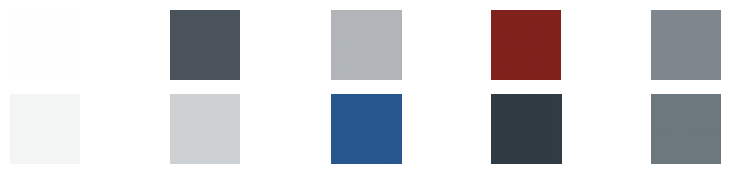

In [116]:
print(centers)
# show 10 color patches
histogram = {}
plt.figure(figsize=(10, 2))
for i, color in enumerate(centers):
    # count number of pixels in each cluster
    count = np.sum(np.all(original_clustered == color, axis=-1))
    histogram[i] = count
    if i<10:
        plt.subplot(2, 5, i+1)
        plt.imshow(np.ones((100, 100, 3)) * color/255)
        plt.axis('off')
histogram, sum(histogram.values())

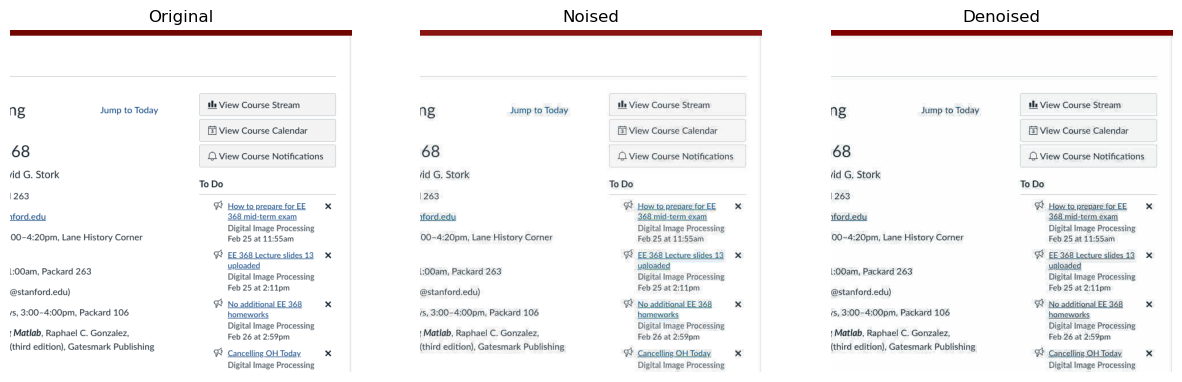

7.036821997935331e-06


In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (img, title) in enumerate(zip([original, noised, denoised], ["Original", "Noised", "Denoised"])):
    axes[i].imshow(normalize(img[:,:, :]))
    axes[i].set_title(title)
    axes[i].axis("off")
plt.show()
print(np.mean(noised - denoised))

array([[[0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        ...,
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ]],

       [[0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        ...,
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ]],

       [[0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        ...,
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ],
        [0.48853753, 0.00337549, 0.        ]],

       ...,

       [[0.99917533, 1.        , 0.99999671],
        [0.99917533, 1.        , 0.99999671],
        [0.99917533, 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


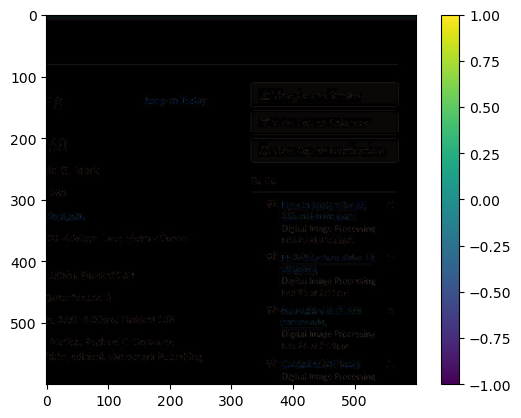

In [21]:
plt.imshow(normalize(noised)-normalize(denoised), vmin=-1, vmax=1)
plt.colorbar()